In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="yogeshwar@17",
                           database="project")
cur=db.cursor()

# 1. List all unique cities where customers are located.


In [50]:
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["City_Name"])
df.head(10)

,City_Name
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# 2. Count the number of orders placed in 2017.

In [11]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2019 are",data[0] [0]


('total orders placed in 2019 are', 90202)

# 3. Find the total sales per category.

In [54]:
query="""SELECT upper(products.product_category ),round(sum(payments.payment_value),2) 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category
"""
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["product_category","total_sales"])
df
# sns.barplot(data=df,y="total_sales",x="product_category")
# plt.plot()

,product_category,total_sales
0,PERFUMERY,2026954.64
1,FURNITURE DECORATION,5720705.57
2,TELEPHONY,1947528.20
3,BED TABLE BATH,6850214.68
4,AUTOMOTIVE,3409177.32
...,...,...
69,CDS MUSIC DVDS,4797.72
70,LA CUISINE,11654.12
71,FASHION CHILDREN'S CLOTHING,3142.68
72,PC GAMER,8697.72


# 4. Calculate the percentage of orders that were paid in installments.

In [52]:
query="""select sum(case when payment_installments >= 1 then 1 else 0 end)/count(*)*100 from payments """
cur.execute(query)
data=cur.fetchall()
"the percentage of orders that are paid in installments",data[0][0]

('the percentage of orders that are paid in installments', Decimal('99.9981'))

# 5. Count the number of customers from each state. 


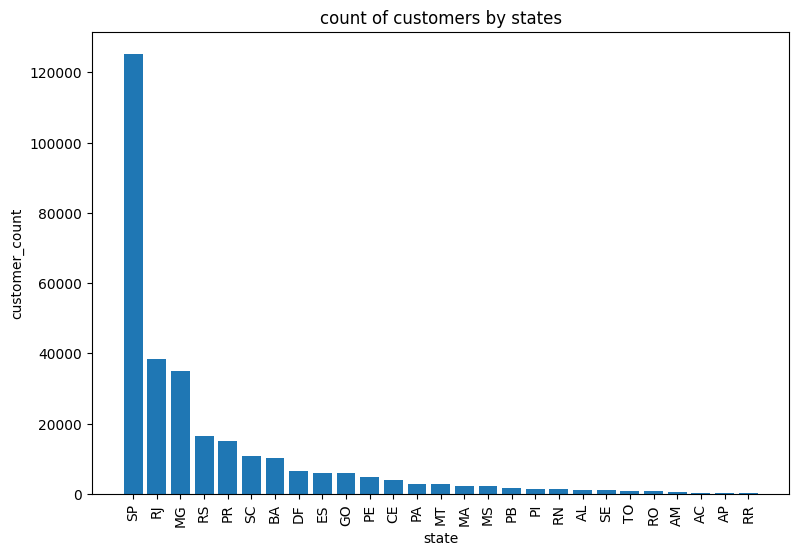

In [100]:
query="""select customer_state,count(customer_id) from project.customers group by customer_state """
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by = "customer_count",ascending=False)
plt.figure(figsize = (9,6))
plt.bar(df["state"],df["customer_count"])

plt.xticks(rotation=90)
plt.xlabel("state")
plt.ylabel("customer_count")
plt.title("count of customers by states")
plt.plot()
plt.savefig("bar.png")

# 6. Calculate the number of orders per month in 2018.

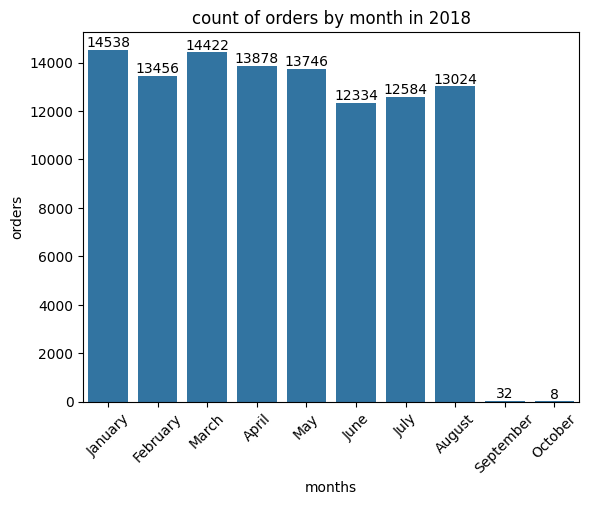

In [34]:
query="""select monthname(order_purchase_timestamp)months,count(order_id) order_count
from project.orders where year(order_purchase_timestamp)=2018 
group by months"""
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["months","orders"])

df

o=["January","February","March","April","May","June","July","August","September","October"]
ax=sns.barplot(data=df,x=df["months"],y=df["orders"],order=o)
plt.xticks(rotation=45)
plt.title("count of orders by month in 2018")
ax.bar_label(ax.containers[0])
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

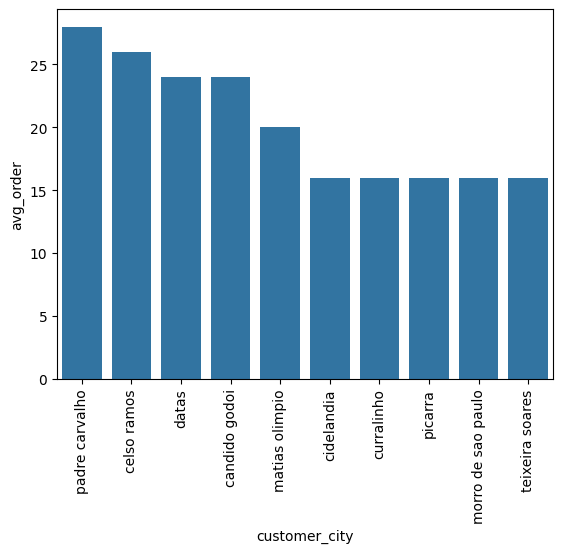

In [36]:
query="""with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id)as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2)average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["customer_city","avg_order"])
df.head(10)

sns.barplot(data=df,x=df.head(10)["customer_city"],y=df.head(10)["avg_order"])
plt.xticks(rotation=90)
plt.show()

# 8. Calculate the percentage of total revenue contributed by each product category.

In [26]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()
# plt.pie(df.head(10)["sales_percentage"],labels=df.head(10)["product_category"])
# plt.show()

,Category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


# 9.Identify the correlation between product price and the number of times a product has been purchased.

In [34]:
query="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
data

df=pd.DataFrame(data,columns=["product_category","order_count","avg_price"])
df

arr1= df["order_count"]
arr2= df["avg_price"]

a=np.corrcoef([arr1,arr2])
print("the correlation between price and number of times product has been purchased is",a[0][1])

the correlation between price and number of times product has been purchased is -0.10631514167157562


# 10.Calculate the total revenue generated by each seller, and rank them by revenue.


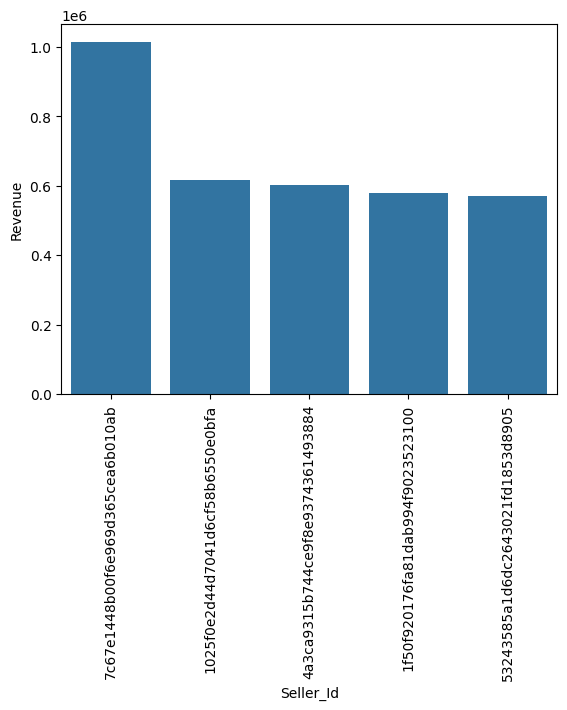

In [49]:
query="""select *, dense_rank()over(order by revenue desc) as rn from
(SELECT order_items.seller_id, round(sum(payments.payment_value),2) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by  order_items.seller_id) as a"""

cur.execute(query)
data= cur.fetchall()
data

# round(sum(payments.payment_value),2) revenue

df=pd.DataFrame(data,columns=["Seller_Id","Revenue","Rank"])
df=df.head()
sns.barplot(x="Seller_Id",y="Revenue",data=df)
plt.xticks(rotation = 90)
plt.show()



# 11.Calculate the moving average of order values for each customer over their order history.

In [26]:
query="""select customer_id,payment,order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["order_id","payment_value","time","avg"])
df

,order_id,payment_value,time,avg
0,00012a2ce6f8dcda20d059ce98491703,114.74,2017-11-14 16:08:26,114.739998
1,00012a2ce6f8dcda20d059ce98491703,114.74,2017-11-14 16:08:26,114.739998
2,000161a058600d5901f007fab4c27140,67.41,2017-07-16 09:40:32,67.410004
3,000161a058600d5901f007fab4c27140,67.41,2017-07-16 09:40:32,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,195.42,2017-02-28 11:06:43,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,214.13,2018-06-13 16:57:05,214.130005
207768,ffffa3172527f765de70084a7e53aae8,45.50,2017-09-02 11:53:32,45.500000
207769,ffffa3172527f765de70084a7e53aae8,45.50,2017-09-02 11:53:32,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,18.37,2017-09-29 14:07:03,18.370001


# 12. Calculate the cumulative sales per month for each year.

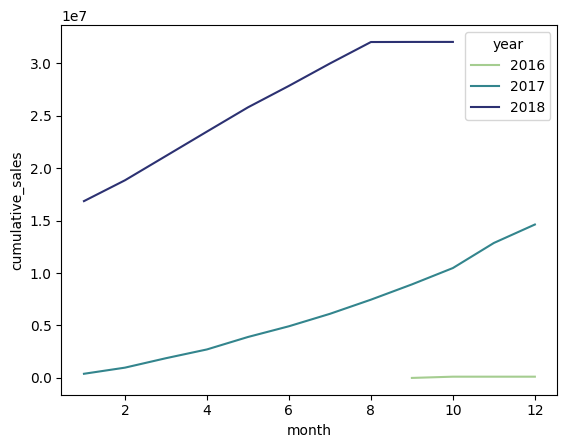

In [47]:
query=""" select years,months,payment,sum(payment)
over (order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp)as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years,months asc) as a"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["year","month","payment","cumulative_sales"])
df
sns.lineplot(data=df,x="month",y="cumulative_sales",hue="year",palette="crest")
plt.show()

# 13. Calculate the year-over-year growth rate of total sales.

In [59]:
query="""with a as
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as sales
from orders join payments
on orders.order_id = payments.order_id
group by years order by years asc) 

select years,sales,(sales-lag(sales,1)over(order by years))/
lag(sales,1)over(order by years)*100 growth_rate from a"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["year","sales","growth_rate%"])
df

# sns.barplot(data=df,x="year",y="growth_rate%")
# plt.show()

,year,sales,growth_rate%
0,2016,118724.68,NaN
1,2017,14499493.46,12112.703761
2,2018,17399526.10,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [6]:
query="""with a as(SELECT customers.customer_id,
min(orders.order_purchase_timestamp)first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customer_id),

 b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp >first_order
and  orders.order_purchase_timestamp < 
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct(b.customer_id))) 
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)
data=cur.fetchall()

a="There are no customers who purchased after 6 months of their first purchase.That's why retention rate is null",data
a

("There are no customers who purchased after 6 months of their first purchase.That's why retention rate is null",
 [(None,)])

# 15. Identify the top 3 customers who spent the most money in each year.

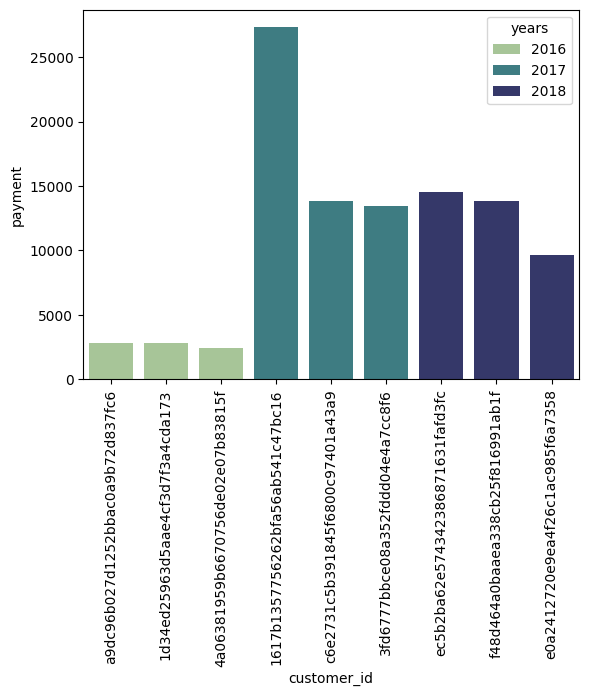

In [46]:
query="""select years,customer_id,payment,drank 
from 
(SELECT year(orders.order_purchase_timestamp)years ,orders.customer_id, sum(payments.payment_value)payment,
dense_rank() over( partition by year(order_purchase_timestamp) 
order by sum(payments.payment_value) desc) drank
from payments join orders
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a
where drank <=3"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["years","customer_id","payment","rank"])
df

sns.barplot(data=df, x="customer_id",y="payment",hue="years",palette="crest")
plt.xticks(rotation=90)
plt.show()
